# Testing

In [37]:
import pandas as pd


data = pd.read_pickle("./Energy_graph/data/watts_test/SMART.pkl")



In [14]:
df.iloc[:,0]

Time
2013-10-09 13:06:16    74.0
2013-10-09 13:06:24    75.0
2013-10-09 13:06:32    75.0
2013-10-09 13:06:40    74.0
2013-10-09 13:06:48    74.0
                       ... 
2015-07-10 11:56:00     0.0
2015-07-10 11:56:08     0.0
2015-07-10 11:56:16     0.0
2015-07-10 11:56:24     0.0
2015-07-10 11:56:32     0.0
Name:  fridge, Length: 6003014, dtype: float64

In [2]:
# Assuming 'df' is your DataFrame and 'device' is the column with device data
threshold = 5  # Define the threshold for 'on' state
df['above_threshold'] = (df[device] >= threshold).astype(int)
df['rolling_sum'] = df['above_threshold'].rolling(window=6, min_periods=1).sum()

# Define 'on' state as being above threshold for more than 5 consecutive rows
df['state'] = (df['rolling_sum'] > 5).astype(int)
df['state_change'] = df['state'].diff()

# Find start and end times of 'on' events
on_starts = df.index[df['state_change'] == 1].tolist()
on_ends = df.index[df['state_change'] == -1].tolist()

# Adjust for edge cases (e.g., if the series starts or ends with an 'on' state)
if df['state'].iloc[0] == 1:
    on_starts.insert(0, df.index[0])
if df['state'].iloc[-1] == 1:
    on_ends.append(df.index[-1])

# Define the number of rows to add before and after
rows_to_add = 0

# Extract 'on' periods with additional rows
on_periods = []
for start, end in zip(on_starts, on_ends):
    start_index = df.index.get_loc(start)
    end_index = df.index.get_loc(end)

    # Adjust start and end index to add additional rows
    start_index = max(start_index - rows_to_add, 0)
    end_index = min(end_index + rows_to_add, len(df) - 1)

    on_period = df.iloc[start_index:end_index + 1]
    on_periods.append(on_period)

# Merging close 'on' events
merged_on_starts = [on_starts[0]]
merged_on_ends = [on_ends[0]]  # Initialize with the first 'end' event

for i in range(1, len(on_starts)):
    start_index = df.index.get_loc(on_starts[i])
    end_index = df.index.get_loc(merged_on_ends[-1])

    # If the gap between the end of the previous event and the start of the current event is less than 10 rows
    if start_index - end_index < 10:
        continue  # Skip this start, as it's part of the ongoing event
    else:
        merged_on_ends.append(on_ends[i - 1])
        merged_on_starts.append(on_starts[i])

# Ensure the last end is added
if df['state'].iloc[-1] == 1:
    merged_on_ends[-1] = on_ends[-1]
else:
    merged_on_ends.append(on_ends[-1])

# Extract 'on' periods with additional rows considering merged events
merged_on_periods = []
for start, end in zip(merged_on_starts, merged_on_ends):
    start_index = df.index.get_loc(start)
    end_index = df.index.get_loc(end)

    # Adjust start and end index to add additional rows
    start_index = max(start_index - rows_to_add, 0)
    end_index = min(end_index + rows_to_add, len(df) - 1)

    merged_on_period = df.iloc[start_index:end_index + 1]
    merged_on_periods.append(merged_on_period)


### Average on event kWh usage

0.03346957053609394


<AxesSubplot: xlabel='Time'>

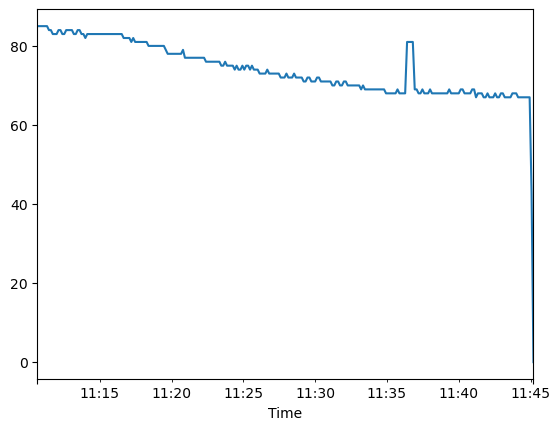

In [7]:
from random import randint
import numpy as np
ix = randint(0, len(on_periods))
# device = " television site"
sampling_rate = 8
maxes = []
for p in on_periods:
    # p[" television site"].max()
    d = p[device].copy()
    d/=1000
    d *= sampling_rate/3600
    time=(p.index[-1] - p.index[0]).total_seconds() / 3600
    # break
    maxes.append(d.sum())

print(np.array(maxes).mean())
on_periods[ix][device].plot()

### Mean, median, Max watts usage per event

In [5]:
from random import randint
import numpy as np
ix = randint(0, len(on_periods))
# device = " television site"
sampling_rate = 8
means = []
maxes = []
median = []
for p in on_periods:
    # p[" television site"].max()
    d = p[device].copy()
    means.append(d.mean())
    maxes.append(d.max())
    median.append(d.median())

 

print("Mean: ",np.array(means).mean(), " Max: ",np.array(maxes).mean(), " Median: ",np.array(median).mean(), " Std: ",np.array(means).std())
# on_periods[ix][device].plot()

Mean:  68.19256086421382  Max:  83.7671474830733  Median:  68.11414483367678  Std:  68.1541477327425


### Average daily

In [3]:

time_deltas = df.index.to_series().diff().dropna()
median_time_delta = time_deltas.median()
sampling_rate = median_time_delta.total_seconds()/3600

print("Sampling rate: ", sampling_rate)
df/=1000
df *= sampling_rate
df

Sampling rate:  0.0022222222222222222


,fridge
Time,
2013-10-09 13:06:16,0.000164
2013-10-09 13:06:24,0.000167
2013-10-09 13:06:32,0.000167
2013-10-09 13:06:40,0.000164
2013-10-09 13:06:48,0.000164
...,...
2015-07-10 11:56:00,0.000000
2015-07-10 11:56:08,0.000000
2015-07-10 11:56:16,0.000000


In [5]:
df = df.resample('1D').sum()

print(df.mean())
df

 fridge    0.367798
dtype: float64


,fridge
Time,
2013-10-09,0.132729
2013-10-10,0.383987
2013-10-11,0.318136
2013-10-12,0.301636
2013-10-13,0.276747
...,...
2015-07-06,0.552102
2015-07-07,0.558164
2015-07-08,0.480053


### Functions

In [5]:
import numpy as np
def average_daily_consumption(df: pd.DataFrame):
    """Returns the average daily consumption of a device in kWh."""
    df = df.copy()
    time_deltas = df.index.to_series().diff().dropna()
    median_time_delta = time_deltas.median()
    sampling_rate = median_time_delta.total_seconds()/3600
    df/=1000
    df *= sampling_rate
    df = df.resample('1D').sum()
    return df.values.mean()    

def average_on_off_event(df: pd.DataFrame):
    """Returns the average on and off event of a device in kWh."""

    df_orig = df.copy()
    time_deltas = df.index.to_series().diff().dropna()
    median_time_delta = time_deltas.median()
    sampling_rate = median_time_delta.total_seconds()/3600

    threshold = 5  # Define the threshold for 'on' state
    df['above_threshold'] = (df >= threshold).astype(int)
    df['rolling_sum'] = df['above_threshold'].rolling(window=6, min_periods=1).sum()

    # Define 'on' state as being above threshold for more than 5 consecutive rows
    df['state'] = (df['rolling_sum'] > 5).astype(int)
    df['state_change'] = df['state'].diff().fillna(0)


    # Find start and end times of 'on' events
    on_starts = df_orig.index[df['state_change'] == 1].tolist()
    on_ends = df_orig.index[df['state_change'] == -1].tolist()



    # Adjust for edge cases (e.g., if the series starts or ends with an 'on' state)
    if df['state'].iloc[0] == 1:
        on_starts.insert(0, df.index[0])
    if df['state'].iloc[-1] == 1:
        on_ends.append(df.index[-1])

    # Extract 'on' periods with additional rows
    on_periods = []
    for start, end in zip(on_starts, on_ends):
        start_index = df.index.get_loc(start)
        end_index = df.index.get_loc(end)

        # Adjust start and end index to add additional rows
        start_index = max(start_index , 0)
        end_index = min(end_index, len(df) - 1)

        on_period = df.iloc[start_index:end_index + 1]
        on_periods.append(on_period)

    # Merging close 'on' events
    merged_on_starts = [on_starts[0]]
    merged_on_ends = [on_ends[0]]  # Initialize with the first 'end' event

    for i in range(1, len(on_starts)):
        start_index = df.index.get_loc(on_starts[i])
        end_index = df.index.get_loc(merged_on_ends[-1])

        # If the gap between the end of the previous event and the start of the current event is less than 10 rows
        if start_index - end_index < 10:
            continue  # Skip this start, as it's part of the ongoing event
        else:
            merged_on_ends.append(on_ends[i - 1])
            merged_on_starts.append(on_starts[i])

    # Ensure the last end is added
    if df['state'].iloc[-1] == 1:
        merged_on_ends[-1] = on_ends[-1]
    else:
        merged_on_ends.append(on_ends[-1])

    # Extract 'on' periods with additional rows considering merged events
    merged_on_periods = []
    for start, end in zip(merged_on_starts, merged_on_ends):
        start_index = df.index.get_loc(start)
        end_index = df.index.get_loc(end)

        # Adjust start and end index to add additional rows
        start_index = max(start_index , 0)
        end_index = min(end_index , len(df) - 1)

        merged_on_period = df.iloc[start_index:end_index + 1]
        merged_on_periods.append(merged_on_period)

    avg = []
    for p in merged_on_periods:
        p = p.iloc[:,0].copy()
        p/=1000
        p *= sampling_rate
        
        # break
        avg.append(p.sum())

    return np.array(avg).mean()

    


In [1]:
# average_daily_consumption(df), average_on_off_event(df)
import pandas as pd


data = pd.read_pickle("./Energy_graph/data/watts_test/ENERTALK.pkl")


In [6]:

for k in data.keys():
    print(k)
    df = data[k]
    for d in df.keys():
        print(d)
        if "aggregate" in d:
            print("daily: ",average_daily_consumption(df[d].copy()))
        else:
            print("daily: ",average_daily_consumption(df[d].copy()))
            print("event: ",average_on_off_event(df[d].copy()))

ENERTALK_20
fridge
daily:  14.053189174327956
event:  4.166041929713804e-07
aggregate
daily:  134.34280407522402
kimchi-fridge
daily:  5.313733748342293
event:  4.4055912826009294e-09
rice-cooker
daily:  0.8496392738351256
event:  3.990689732933862e-10
ENERTALK_12
aggregate
daily:  61.935762118100364
washing-machine
daily:  0.5935416394713262
event:  7.760834003754357e-06
fridge
daily:  23.61895152414874
event:  3.9664815778818897e-07
rice-cooker
daily:  3.477104776904122
event:  0.0002063300768272425
TV
daily:  5.225170703606631
event:  1.3256425109193565e-06
kimchi-fridge
daily:  6.180451818817204
event:  1.1115854996813611e-07
ENERTALK_18
aggregate
daily:  188.44403946122225
washing-machine
daily:  4.5324469406666665
event:  0.011579030070842655
fridge
daily:  21.962347582444444
event:  3.6513018633133575e-06
kimchi-fridge
daily:  13.241707034166666
event:  4.862272159800251e-06
TV
daily:  8.358822484
event:  9.339684446142927e-08
ENERTALK_1
TV
daily:  11.317009747110214
event:  1.1

KeyboardInterrupt: 

In [7]:
for h in data.keys():
    # print(h)
    df = data[h]
    for d in df.keys():
        if d != "aggregate":
            print(d)
            